In [1]:
import jax
import jax.numpy as jnp
import jax.random as jxr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

import sys
sys.path.append('../')
import utils
from models import wGPLDS, WeightSpaceGaussianProcess

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
n_neurons = 2
latent_dim = 2
peaks = jnp.linspace(-jnp.pi, jnp.pi, n_neurons + 1)[:-1]  # tuning curve peaks
widths = 0.1 * jnp.ones(n_neurons)  # tuning curve widths
epsilon = 0.1
noise_scale = 0.1

In [3]:
@partial(jax.vmap, in_axes=(0, 0))
def dynamics(theta, omega):
    theta = (theta % (2 * jnp.pi)) - jnp.pi
    u = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    v = jnp.array([-jnp.sin(theta), jnp.cos(theta)])
    A = (1 - epsilon) * v[:, None] * v[None, :]
    b = u + omega * v
    z = jnp.clip(theta - peaks, -jnp.pi * widths, jnp.pi * widths)
    C = (1 + jnp.cos(z / widths))[:, None] * (
        jnp.tile(u[None, :], (n_neurons, 1))
    )
    return (A, b, C)

def initial_condition(theta, omega):
    m0 = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    S0 = noise_scale * jnp.eye(2)
    return (m0, S0)

def run_dynamics(key, As, bs, Cs, m0, S0):

    def f(x, inp):
        A, b, C, (subkey1, subkey2) = inp
        emission_noise = noise_scale * (
            jxr.multivariate_normal(subkey2, jnp.zeros(n_neurons), jnp.eye(n_neurons))
        )
        y = C @ x + emission_noise

        dynamics_noise = noise_scale * (
            jxr.multivariate_normal(subkey1, jnp.zeros(2), jnp.eye(2))
        )
        x_next = A @ x + b + dynamics_noise
        return x_next, (x_next, y)

    x_init = jxr.multivariate_normal(key, m0, S0)
    subkeys = jxr.split(key, num=(As.shape[0],2))
    _, (x_nexts, ys) = jax.lax.scan(f, x_init, xs=(As, bs, Cs, subkeys))
    # print(x_init)
    # print(x_nexts[0])
    xs = jnp.concatenate([x_init[None, :], x_nexts[:-1]], axis=0)
    return xs, ys

Text(0.5, 1.0, 'heading direction over time')

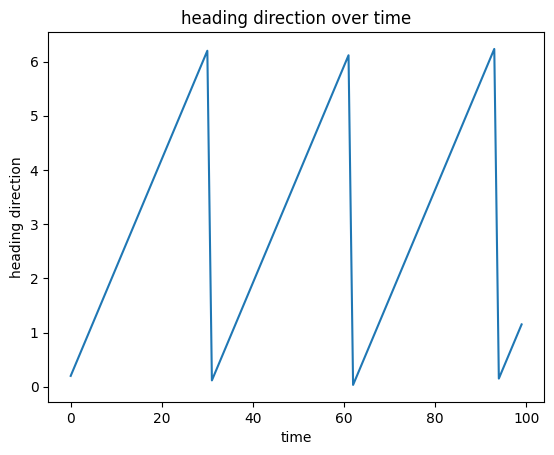

In [4]:
# Sample heading direction with constant velocity
num_timesteps = 100
speed = 0.2
omega = jnp.ones(num_timesteps) * speed
theta = jnp.cumsum(omega)

# Plot heading direction trajectory
plt.plot(theta % (2 * jnp.pi))
plt.ylabel('heading direction')
plt.xlabel('time')
plt.title('heading direction over time')

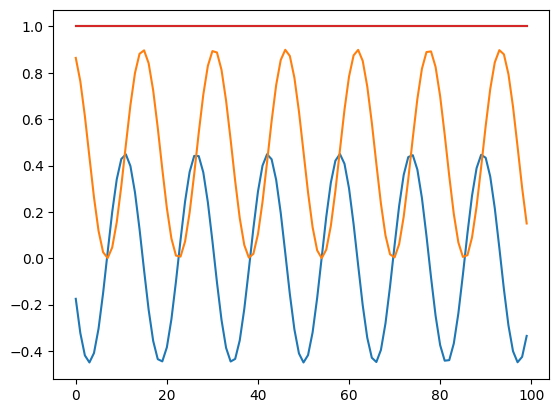

In [5]:
# Generate time-varying linear dynamics and initial condition
true_As, true_bs, true_Cs = dynamics(theta, omega)
true_bs = jnp.ones((num_timesteps, 2))
true_Cs = jnp.tile(jnp.eye(2), (num_timesteps, 1, 1))
true_m0, true_S0 = initial_condition(theta[0], omega[0])

# Run the dynamics to get a batch of data
B = 100
X, Y = jax.vmap(
    lambda i: run_dynamics(jxr.PRNGKey(i), true_As, true_bs, true_Cs, true_m0, true_S0)
    )(jnp.arange(B))

partition = int(0.8 * B)
X_train, Y_train = X[:partition], Y[:partition]
X_test, Y_test = X[partition:], Y[partition:]

# plt.plot(Y[0, :])
plt.plot(true_As[:,1])
plt.plot(true_bs)

In [6]:
run_dynamics(jxr.PRNGKey(0), true_As, true_bs, true_Cs, true_m0, true_S0)[1].shape

(100, 2)

[-0.010390996932983398, 0.12701952457427979, 0.30003929138183594, 0.4815628230571747, 0.6374754309654236, 0.7455251812934875, 0.8088316321372986, 0.8553494811058044, 0.9228575229644775, 1.0369369983673096, 1.1927586793899536, 1.3495622873306274, 1.4412131309509277, 1.3996540307998657, 1.1826300621032715, 0.7946223020553589, 0.29167085886001587, -0.2333546280860901, -0.6804001331329346, -0.9751838445663452, -1.0916332006454468, -1.054267406463623, -0.9205412864685059, -0.7531540989875793, -0.596899151802063, -0.4704769253730774, -0.37335339188575745, -0.2983555495738983, -0.2391294240951538, -0.18854403495788574, -0.13342604041099548, -0.054521605372428894, 0.06460505723953247, 0.22513775527477264, 0.4072771668434143, 0.5776467323303223, 0.7068450450897217, 0.7865872383117676, 0.8355897665023804, 0.8900542855262756, 0.983310878276825, 1.124725103378296, 1.288119912147522, 1.4156595468521118, 1.4367204904556274, 1.2951321601867676, 0.9742678999900818, 0.5094023942947388, -0.0189611315727

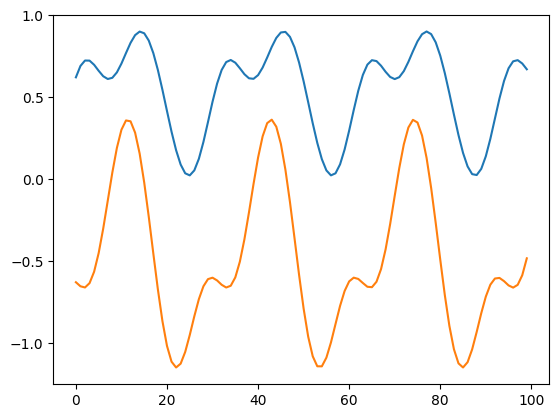

In [7]:
# Define model

_sigma, _kappa, _period = 0.5, 0.2, 2*jnp.pi
torus_basis_funcs = utils.torus_basis(3, _sigma, _kappa, _period)

A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=latent_dim)
b_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=1)
model = wGPLDS(wgps={'A': A_prior, 'b': b_prior}, state_dim=latent_dim, emission_dim=n_neurons,)

plt.plot(A_prior.sample(jxr.PRNGKey(0), theta)[:,0,0])
plt.plot(A_prior.sample(jxr.PRNGKey(0), theta)[:,0,1])

print([jnp.linalg.det(_F).item() for _F in A_prior.sample(jxr.PRNGKey(0), theta)])

In [8]:
from models import ParamswGPLDS
initial_params = ParamswGPLDS(
    dynamics_gp_weights = A_prior.weights(jxr.PRNGKey(0)),
    Q = 0.1 * jnp.eye(latent_dim),
    R = 0.1 * jnp.eye(n_neurons),
    m0 = jnp.zeros(latent_dim),
    S0 = jnp.eye(latent_dim),
    Cs = true_Cs,
    bs = true_bs,
)

thetas_train = jnp.tile(theta[:-1], (B, 1))[:partition]
params, log_probs = model.fit_em(initial_params, emissions=Y_train, inputs=thetas_train, num_iters=20)

# Where does the nan come from? came from S0

Iter 1/20, marginal log-likelihood = -219671.8125
Iter 2/20, marginal log-likelihood = -333562.53125
Iter 3/20, marginal log-likelihood = -280984.46875
Iter 4/20, marginal log-likelihood = -182589.8125
Iter 5/20, marginal log-likelihood = -133774.90625
Iter 6/20, marginal log-likelihood = -81372.125
Iter 7/20, marginal log-likelihood = -74899.234375
Iter 8/20, marginal log-likelihood = -64538.390625
Iter 9/20, marginal log-likelihood = -60951.48046875
Iter 10/20, marginal log-likelihood = -57892.2890625
Iter 11/20, marginal log-likelihood = -56048.6328125
Iter 12/20, marginal log-likelihood = -54662.38671875


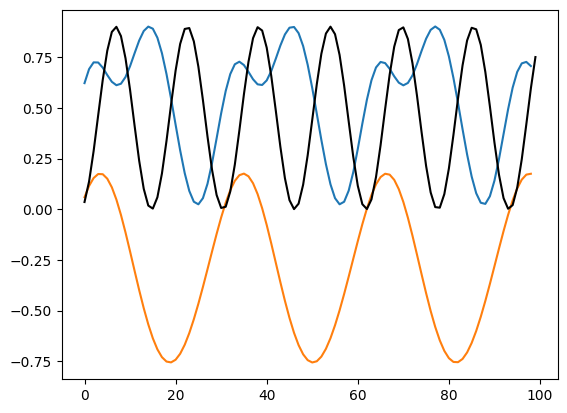

In [ ]:
plt.plot(A_prior(initial_params.dynamics_gp_weights, theta[:-1])[:,0,0])
plt.plot(A_prior(params.dynamics_gp_weights, theta[:-1])[:,0,0])
plt.plot(true_As[:,0,0], c='k')

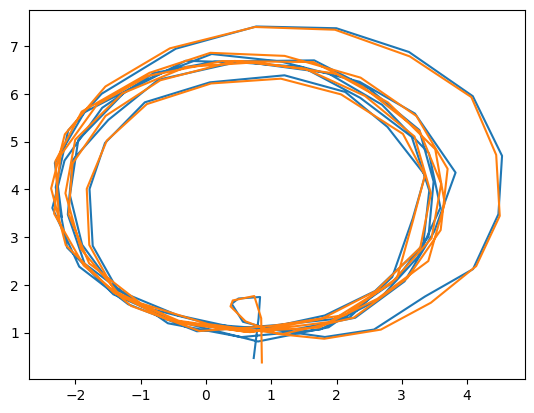

In [ ]:
_, (filtered_means, _), (smoothed_means, _, _) = utils.lgssm_smoother(
    m0 = true_m0,
    S0 = true_S0,
    As = true_As,
    bs = true_bs,
    Cs = true_Cs,
    Q = noise_scale * jnp.eye(2),
    R = noise_scale * jnp.eye(n_neurons),
    ys = Y_train[0],
)

plt.plot(X_train[0, :, 0], X_train[0, :, 1], label='true')
plt.plot(smoothed_means[:, 0], smoothed_means[:, 1], label='smoothed')

In [ ]:
true_As.shape

(100, 2, 2)

In [ ]:
smoothed_means

Array([[ 0.85682935,  0.37613982],
       [ 0.8464035 ,  1.301439  ],
       [ 0.7403925 ,  1.7662928 ],
       [ 0.4108995 ,  1.6742171 ],
       [ 0.37641045,  1.5501794 ],
       [ 0.60623837,  1.2372602 ],
       [ 1.1144887 ,  0.969603  ],
       [ 1.8105891 ,  0.8726236 ],
       [ 2.6791692 ,  1.0638676 ],
       [ 3.4452314 ,  1.6265314 ],
       [ 4.1391296 ,  2.3924606 ],
       [ 4.5002265 ,  3.4437187 ],
       [ 4.445761  ,  4.7201076 ],
       [ 4.065826  ,  5.928895  ],
       [ 3.1224575 ,  6.78074   ],
       [ 1.9758002 ,  7.339051  ],
       [ 0.7513207 ,  7.396075  ],
       [-0.5521277 ,  6.9495645 ],
       [-1.5392616 ,  6.151677  ],
       [-2.1613786 ,  5.149643  ],
       [-2.3708565 ,  4.017056  ],
       [-2.146662  ,  2.8318465 ],
       [-1.4099123 ,  1.8361645 ],
       [-0.41710585,  1.2484101 ],
       [ 0.73108065,  1.0242804 ],
       [ 1.8902241 ,  1.2237363 ],
       [ 2.8364508 ,  2.0313041 ],
       [ 3.456179  ,  2.9763172 ],
       [ 3.6027153 ,